In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as patheffects
from sklearn.metrics import r2_score
from tqdm.notebook import tqdm

In [48]:
import requests
import os

In [49]:
import datetime

In [50]:
COVID_DATA_FILE_LOC = './datasets/covid_data.csv'
ELECTION_RESULTS_FILE_LOC = './datasets/2020_election_results.csv'
CENSUS_POPS_FILE_LOC = './datasets/census_pops.csv'

def download_data(url, filename):
    # Streaming, so we can iterate over the response.
    response = requests.get(url, stream=True)
    total_size_in_bytes= int(response.headers.get('content-length', 0))
    block_size = 1024 #1 Kibibyte
    progress_bar = tqdm(total=total_size_in_bytes, unit='iB', unit_scale=True)
    with open(filename, 'wb') as file:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            file.write(data)
    progress_bar.close()

def download_files(replace=False):
    if not os.path.exists(COVID_DATA_FILE_LOC) or replace:
        print('Downloading NY Times county level covid data...')
        download_data('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', COVID_DATA_FILE_LOC)
    if not os.path.exists(ELECTION_RESULTS_FILE_LOC) or replace:
        print('Downloading webscraped county level presidential election results...')
        download_data('https://raw.githubusercontent.com/tonmcg/US_County_Level_Election_Results_08-20/master/2020_US_County_Level_Presidential_Results.csv',
                     ELECTION_RESULTS_FILE_LOC)
    if not os.path.exists(CENSUS_POPS_FILE_LOC) or replace:
        print('Downloading US Census county level population data...')
        download_data('https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/co-est2019-alldata.csv',
                     CENSUS_POPS_FILE_LOC)
    print('Finished downloading.')

download_files(replace=True)

  0%|          | 0.00/10.0M [00:00<?, ?iB/s]

  0%|          | 0.00/153k [00:00<?, ?iB/s]

  0%|          | 0.00/1.68M [00:00<?, ?iB/s]

Finished downloading.


In [51]:
df = pd.read_csv(COVID_DATA_FILE_LOC)
df.head()

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061.0,1,0.0
1,2020-01-22,Snohomish,Washington,53061.0,1,0.0
2,2020-01-23,Snohomish,Washington,53061.0,1,0.0
3,2020-01-24,Cook,Illinois,17031.0,1,0.0
4,2020-01-24,Snohomish,Washington,53061.0,1,0.0


In [52]:
def calc_days_since(date):
    date = datetime.datetime.strptime(date, '%Y-%m-%d')
    last_date = datetime.datetime.strptime(df['date'].max(), '%Y-%m-%d')
    return (last_date - date).days

# set to None if you want all data from 2020-01-21 to most recent data
# or set to integer value if you want specific days
num_days_to_evaluate = calc_days_since('2020-11-03')

In [53]:
# Don't change
last_date = df['date'].max()
first_date = df['date'].min()
last_date = datetime.datetime.strptime(last_date,'%Y-%m-%d')
if num_days_to_evaluate is None:
    num_days_to_evaluate = (last_date - datetime.datetime.strptime(first_date, '%Y-%m-%d')).days
first_date = last_date - datetime.timedelta(days=num_days_to_evaluate)
first_date = datetime.datetime.strftime(first_date, format='%Y-%m-%d')
last_date = datetime.datetime.strftime(last_date, format='%Y-%m-%d')
print(first_date,last_date)
print('Num days:', num_days_to_evaluate)

2020-11-03 2021-01-20
Num days: 78


In [54]:
df.describe()

,fips,cases,deaths
count,940870.000000,9.497260e+05,929405.000000
mean,31274.960926,2.292120e+03,58.039136
std,16301.568668,1.206846e+04,464.072550
min,1001.000000,0.000000e+00,0.000000
25%,19001.000000,4.200000e+01,0.000000
50%,29217.000000,2.740000e+02,5.000000
75%,46101.000000,1.180000e+03,25.000000
max,78030.000000,1.038495e+06,26249.000000


In [55]:
print('Data goes up to',df['date'].max())

Data goes up to 2021-01-20


Text(0, 0.5, 'Deaths in Bent County')

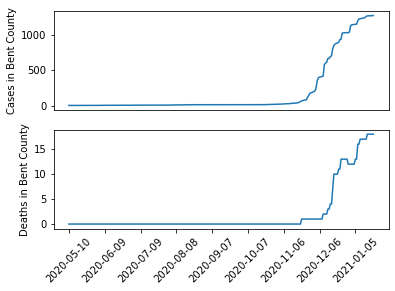

In [56]:
bent = df.loc[(df.state=='Colorado')&(df.county=='Bent')]
plt.subplot(211)
plt.plot(bent['date'],bent['cases'], label='Total Cases')
plt.xticks([])
plt.ylabel('Cases in Bent County')
plt.subplot(212)
plt.xticks(np.arange(0,len(bent['date']),30),rotation=45)
plt.plot(bent['date'],bent['deaths'],label='Total Deaths')
plt.ylabel('Deaths in Bent County')

#print('Population of Bent County:', 
 #     election_covid_pops.loc[(election_covid_pops.state=='Colorado')&(election_covid_pops.county=='Bent')]['POPESTIMATE2019'])

In [57]:
covid_sums_latest = df.loc[(df.date<=last_date)].groupby(by='fips').max()
covid_sums_n_days_ago = df.loc[df.date==first_date].groupby(by='fips').max()
#covid_sums['deaths in last two weeks'] = covid_sums['deaths'].subtract(
 #   df.loc[(df.date=='2021-01-01') & (~df.index.duplicated())]['deaths'])
covid_sums = covid_sums_latest[['county','state']]
covid_sums.loc[:,f'cases last {num_days_to_evaluate} days'] = covid_sums_latest['cases'] - covid_sums_n_days_ago['cases']
covid_sums.loc[:,f'deaths last {num_days_to_evaluate} days'] = covid_sums_latest['deaths'] - covid_sums_n_days_ago['deaths']
covid_sums.head()

C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Tim\anaconda3\envs\tensorflow\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,county,state,cases last 78 days,deaths last 78 days
fips,,,,
1001.0,Autauga,Alabama,3060.0,24.0
1003.0,Baldwin,Alabama,9658.0,110.0
1005.0,Barbour,Alabama,686.0,27.0
1007.0,Bibb,Alabama,1298.0,33.0
1009.0,Blount,Alabama,3214.0,58.0


In [58]:
election_results = pd.read_csv(ELECTION_RESULTS_FILE_LOC).astype({'county_fips':np.float32})
election_results.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff
0,Alabama,1001.0,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184
1,Alabama,1003.0,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623
2,Alabama,1005.0,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631
3,Alabama,1007.0,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280
4,Alabama,1009.0,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022


In [59]:
election_covid = pd.merge(election_results, covid_sums, right_index=True, left_on='county_fips')
election_covid.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,county,state,cases last 78 days,deaths last 78 days
0,Alabama,1001.0,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184,Autauga,Alabama,3060.0,24.0
1,Alabama,1003.0,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623,Baldwin,Alabama,9658.0,110.0
2,Alabama,1005.0,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631,Barbour,Alabama,686.0,27.0
3,Alabama,1007.0,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280,Bibb,Alabama,1298.0,33.0
4,Alabama,1009.0,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022,Blount,Alabama,3214.0,58.0


In [60]:
county_populations = pd.read_csv(CENSUS_POPS_FILE_LOC, encoding='latin1')
county_populations.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
0,40,3,6,1,0,Alabama,Alabama,4779736,4780125,4785437,...,1.917501,0.578434,1.186314,1.522549,0.563489,0.626357,0.745172,1.090366,1.773786,2.483744
1,50,3,6,1,1,Alabama,Autauga County,54571,54597,54773,...,4.847310,6.018182,-6.226119,-3.902226,1.970443,-1.712875,4.777171,0.849656,0.540916,4.560062
2,50,3,6,1,3,Alabama,Baldwin County,182265,182265,183112,...,24.017829,16.641870,17.488579,22.751474,20.184334,17.725964,21.279291,22.398256,24.727215,24.380567
3,50,3,6,1,5,Alabama,Barbour County,27457,27455,27327,...,-5.690302,0.292676,-6.897817,-8.132185,-5.140431,-15.724575,-18.238016,-24.998528,-8.754922,-5.165664
4,50,3,6,1,7,Alabama,Bibb County,22915,22915,22870,...,1.385134,-4.998356,-3.787545,-5.797999,1.331144,1.329817,-0.708717,-3.234669,-6.857092,1.831952


In [61]:
county_populations = county_populations[['STNAME','CTYNAME','POPESTIMATE2019']]
county_populations.head()

,STNAME,CTYNAME,POPESTIMATE2019
0,Alabama,Alabama,4903185
1,Alabama,Autauga County,55869
2,Alabama,Baldwin County,223234
3,Alabama,Barbour County,24686
4,Alabama,Bibb County,22394


In [62]:
election_covid_pops = pd.merge(election_covid, county_populations, left_on=['state_name','county_name'],
                              right_on=['STNAME','CTYNAME'])
election_covid_pops.drop(['STNAME','CTYNAME'], axis=1, inplace=True)
election_covid_pops.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,county,state,cases last 78 days,deaths last 78 days,POPESTIMATE2019
0,Alabama,1001.0,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184,Autauga,Alabama,3060.0,24.0,55869
1,Alabama,1003.0,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623,Baldwin,Alabama,9658.0,110.0,223234
2,Alabama,1005.0,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631,Barbour,Alabama,686.0,27.0,24686
3,Alabama,1007.0,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280,Bibb,Alabama,1298.0,33.0,22394
4,Alabama,1009.0,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022,Blount,Alabama,3214.0,58.0,57826


In [63]:
election_covid_pops.min()

state_name                      Alabama
county_fips                        1001
county_name            Abbeville County
votes_gop                            60
votes_dem                             4
total_votes                          66
diff                           -1883355
per_gop                       0.0539732
per_dem                       0.0309091
per_point_diff                -0.867524
county                        Abbeville
state                           Alabama
cases last 78 days                    7
deaths last 78 days                   0
POPESTIMATE2019                     169
dtype: object

In [64]:
# State and county with highest democratic leaning
election_covid_pops.iloc[election_covid_pops['per_point_diff'].argmin()][['state_name','county_name','per_dem']]

state_name     District of Columbia
county_name    District of Columbia
per_dem                    0.921497
Name: 290, dtype: object

In [65]:
# State and county with highest GOP leaning
election_covid_pops.iloc[election_covid_pops['per_point_diff'].argmax()][['state_name','county_name','per_gop']]

state_name              Texas
county_name    Roberts County
per_gop              0.961818
Name: 2685, dtype: object

In [66]:
election_covid_pops[f'cases last {num_days_to_evaluate} days per 1000'] = election_covid_pops[f'cases last {num_days_to_evaluate} days'] * 1000 / election_covid_pops['POPESTIMATE2019']
election_covid_pops[f'deaths last {num_days_to_evaluate} days per 1000'] = election_covid_pops[f'deaths last {num_days_to_evaluate} days'] * 1000 / election_covid_pops['POPESTIMATE2019']
election_covid_pops.head()

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,county,state,cases last 78 days,deaths last 78 days,POPESTIMATE2019,cases last 78 days per 1000,deaths last 78 days per 1000
0,Alabama,1001.0,Autauga County,19838,7503,27770,12335,0.714368,0.270184,0.444184,Autauga,Alabama,3060.0,24.0,55869,54.770982,0.429576
1,Alabama,1003.0,Baldwin County,83544,24578,109679,58966,0.761714,0.224090,0.537623,Baldwin,Alabama,9658.0,110.0,223234,43.264019,0.492756
2,Alabama,1005.0,Barbour County,5622,4816,10518,806,0.534512,0.457882,0.076631,Barbour,Alabama,686.0,27.0,24686,27.789030,1.093737
3,Alabama,1007.0,Bibb County,7525,1986,9595,5539,0.784263,0.206983,0.577280,Bibb,Alabama,1298.0,33.0,22394,57.961954,1.473609
4,Alabama,1009.0,Blount County,24711,2640,27588,22071,0.895716,0.095694,0.800022,Blount,Alabama,3214.0,58.0,57826,55.580535,1.003009


In [67]:
election_covid_pops = election_covid_pops.dropna(axis=0)

In [68]:
us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'American Samoa': 'AS',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Guam': 'GU',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY'
}

In [69]:
partisan_lean = election_covid_pops['per_point_diff']
cases_per_1000 = election_covid_pops[f'cases last {num_days_to_evaluate} days per 1000']
deaths_per_1000 = election_covid_pops[f'deaths last {num_days_to_evaluate} days per 1000']
pops = election_covid_pops['POPESTIMATE2019']

In [70]:
def plot(df, y_col, counties_to_mark=None, trend_line=True, filename=None):
    partisan_lean = df['per_point_diff']
    y = df[y_col]
    pops = df['POPESTIMATE2019']
    
    fig = plt.figure(figsize=(35,15))
    ax = plt.gca()
    res_size = fig.get_size_inches()*fig.dpi
    pops_sizes = pops / 250
    plt.scatter(partisan_lean, y, 
                s=pops_sizes, c=partisan_lean, 
                cmap='bwr', edgecolors='k', 
                linewidth=1.5, alpha=.8)
    if trend_line:
        z = np.polyfit(partisan_lean,y,1)
        y_hat = np.poly1d(z)(partisan_lean)
        plt.plot(partisan_lean,y_hat, linewidth=3, c='k')
        text_val = f'R^2 = {y.corr(partisan_lean)**2:.3f}'
        ax.text(.05,.95,text_val,transform=plt.gca().transAxes,
               fontsize=32, verticalalignment='top')
    first_date_datetime = datetime.datetime.strptime(first_date,'%Y-%m-%d')
    last_date_datetime = datetime.datetime.strptime(last_date,'%Y-%m-%d')
    first_date_str = first_date_datetime.strftime('%b %d')
    last_date_str = last_date_datetime.strftime('%b %d %Y')
    dates = f'{first_date_str} to {last_date_str}'
    ax.text(.02,.9,dates,transform=plt.gca().transAxes,
           fontsize=40, c='g', verticalalignment='top')
    if counties_to_mark:
        
        for i,county_state in enumerate(counties_to_mark):
            county = county_state[0]
            state = county_state[1]
            county_in_df = df.loc[(df.state_name==state) & (df.county_name==county)]
            size = county_in_df['POPESTIMATE2019'] / 500
            if len(county_in_df)==0:
                print(county,state)
            x_, y_ = county_in_df['per_point_diff'], county_in_df[y_col]
            x_ = x_.values[0]
            y_ = y_.values[0]
            if i%2==0:
                x_offset = -100
            else:
                x_offset = 5
            i+=1
            ax.annotate(f'{county}, {us_state_abbrev[state]}', (x_, y_), fontsize=16,
                       path_effects=[patheffects.withSimplePatchShadow()],
                       xytext=(x_offset,10),
                       textcoords='offset pixels',
                       arrowprops={'arrowstyle':'-'})
    plt.xlabel('Partisan Lean of County in 2020 Presidential Election', fontsize=20)
    plt.xticks(ticks=np.linspace(-1,1,9),
               labels=['D+100','D+75','D+50','D+25','Even','R+25','R+50','R+75','R+100'])
    if y_col.split(' ')[0]=='cases':
        plt.ylabel(f'CoVID-19 Cases per 1000 People from {first_date} to {last_date}', fontsize=20)
        plt.title('CoVID-19 Per Capita Cases vs. Partisan Leaning in 2020 for Every US County', fontsize=22)
    else:
        plt.ylabel(f'CoVID-19 Deaths per 1000 People from {first_date} to {last_date}', fontsize=20)
        plt.title('CoVID-19 Per Capita Deaths vs. Partisan Leaning in 2020 for Every US County', fontsize=22)
    #plt.ylim([-10,225])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    if filename:
        plt.savefig(filename)
    plt.show()

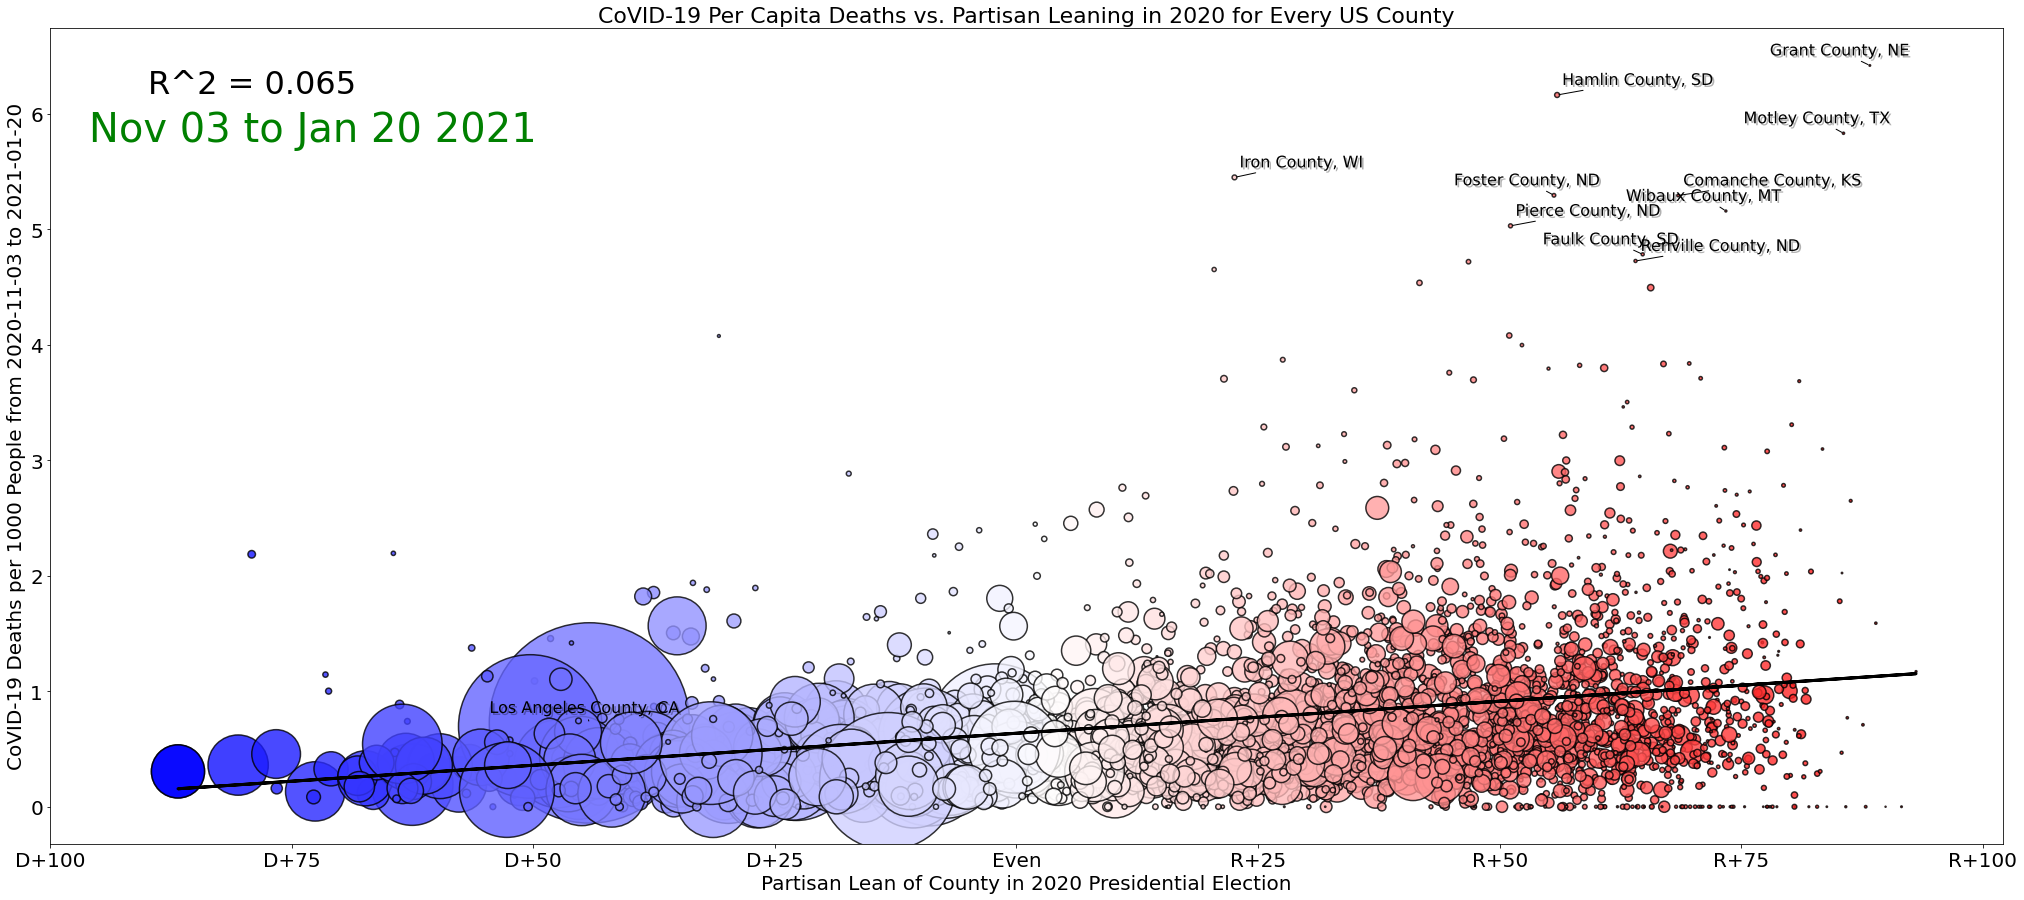

In [71]:
y_col = f'deaths last {num_days_to_evaluate} days per 1000'
highest_cases_counties = election_covid_pops.sort_values(y_col,
                                                         ascending=False)[:10]


highest_tuples = [(val[1]['county_name'],val[1]['state_name']) for val in highest_cases_counties.iterrows()]
other_counties = [('Los Angeles County', 'California')]
plot(election_covid_pops, y_col, counties_to_mark=highest_tuples+other_counties, 
     filename='graphs/deaths_since_2020Election_{}days_ago.png'.format(num_days_to_evaluate))

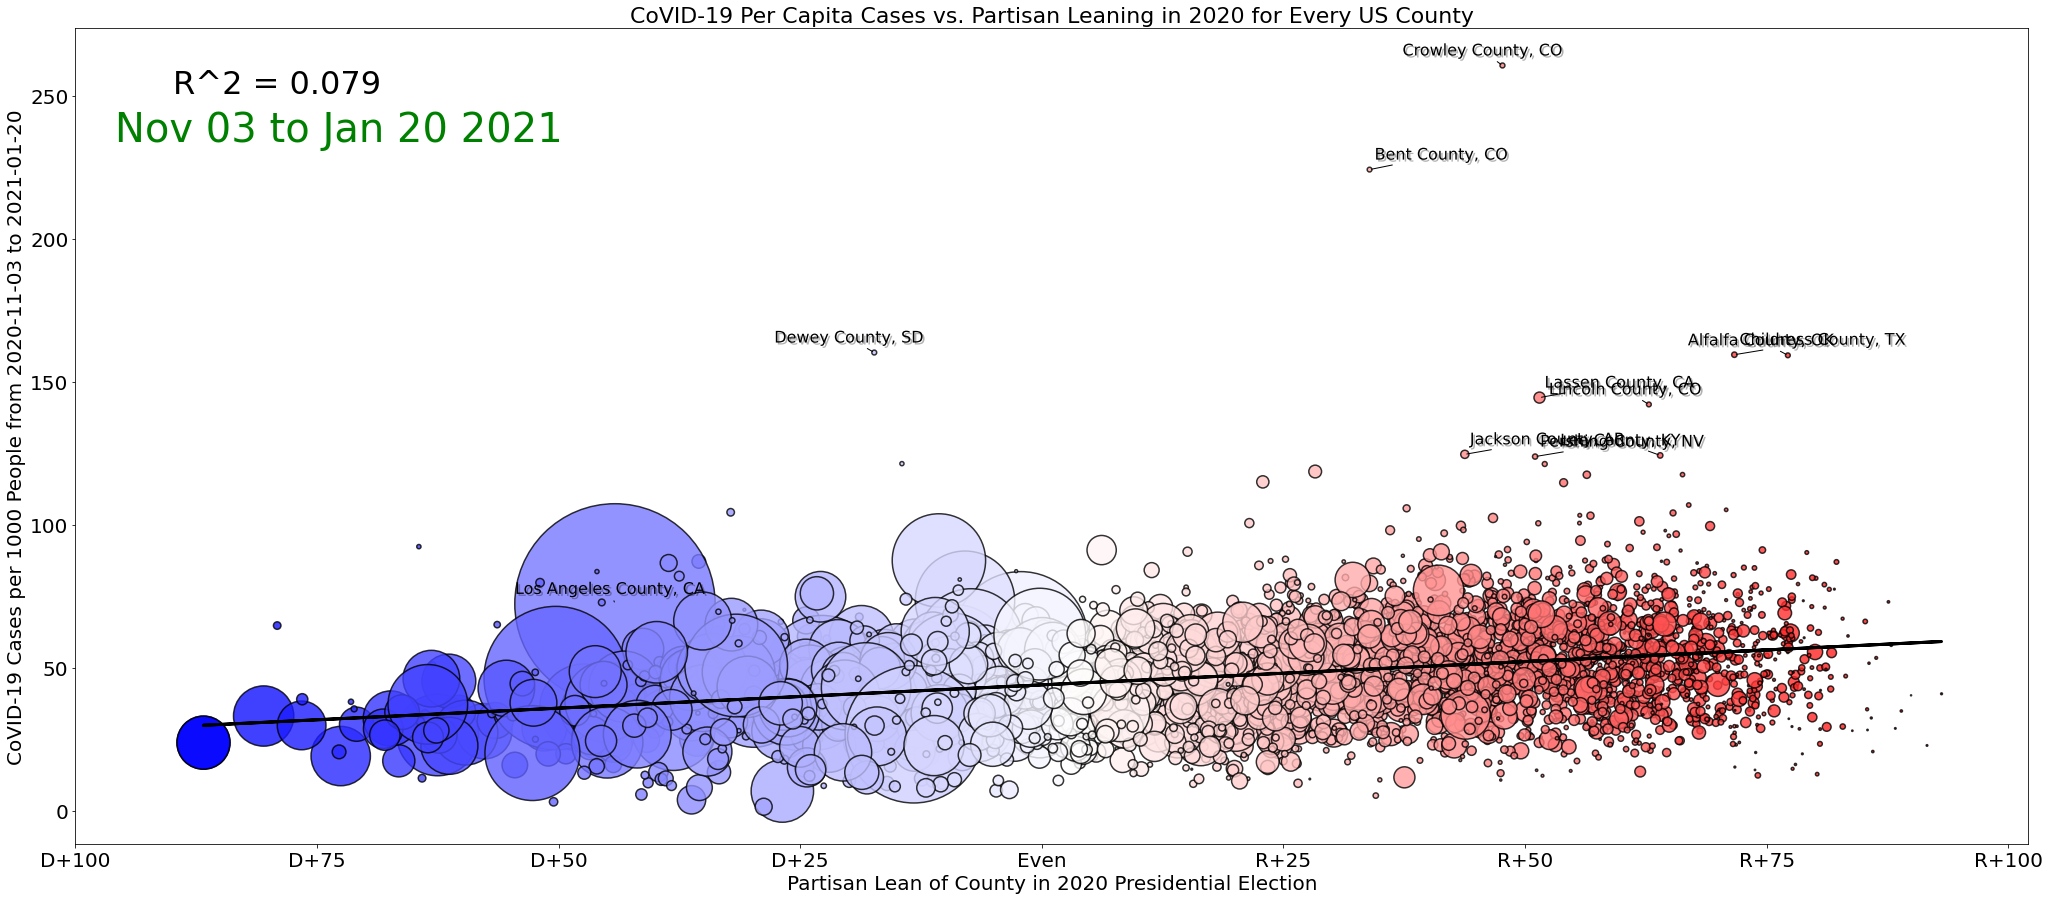

In [72]:
y_col = f'cases last {num_days_to_evaluate} days per 1000'
highest_cases_counties = election_covid_pops.sort_values(y_col,
                                                         ascending=False)[:10]


highest_tuples = [(val[1]['county_name'],val[1]['state_name']) for val in highest_cases_counties.iterrows()]
other_counties = [('Los Angeles County', 'California')]
plot(election_covid_pops, y_col, counties_to_mark=highest_tuples+other_counties, 
     filename='graphs/cases_since_2020Election_{}days_ago.png'.format(num_days_to_evaluate))

In [73]:
election_covid_pops.loc[(election_covid_pops.county_name=='Nassau County') &
                       (election_covid_pops.state_name=='New York')]

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,county,state,cases last 78 days,deaths last 78 days,POPESTIMATE2019,cases last 78 days per 1000,deaths last 78 days per 1000
1826,New York,36059.0,Nassau County,326716,396504,732756,-69788,0.445873,0.541113,-0.09524,Nassau,New York,65463.0,490.0,1356924,48.243675,0.361111


In [74]:
election_covid_pops.sort_values('per_dem', ascending=False)

,state_name,county_fips,county_name,votes_gop,votes_dem,total_votes,diff,per_gop,per_dem,per_point_diff,county,state,cases last 78 days,deaths last 78 days,POPESTIMATE2019,cases last 78 days per 1000,deaths last 78 days per 1000
291,District of Columbia,11001.0,District of Columbia,18586,317323,344356,-298737,0.053973,0.921497,-0.867524,District of Columbia,District of Columbia,16879.0,216.0,705749,23.916435,0.306058
290,District of Columbia,11001.0,District of Columbia,18586,317323,344356,-298737,0.053973,0.921497,-0.867524,District of Columbia,District of Columbia,16879.0,216.0,705749,23.916435,0.306058
1179,Maryland,24033.0,Prince George's County,37090,379208,424855,-342118,0.087300,0.892559,-0.805258,Prince George's,Maryland,30205.0,328.0,909327,33.216874,0.360706
2378,South Dakota,46102.0,Oglala Lakota County,297,2829,3200,-2532,0.092813,0.884062,-0.791250,Oglala Lakota,South Dakota,919.0,31.0,14177,64.823305,2.186640
2906,Virginia,51730.0,Petersburg city,1584,12389,14118,-10805,0.112197,0.877532,-0.765335,Petersburg city,Virginia,1225.0,5.0,31346,39.079946,0.159510
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1585,Montana,30033.0,Garfield County,764,41,813,723,0.939729,0.050431,0.889299,Garfield,Montana,44.0,2.0,1258,34.976153,1.589825
2623,Texas,48269.0,King County,151,8,159,143,0.949686,0.050314,0.899371,King,Texas,11.0,0.0,272,40.441176,0.000000
1662,Nebraska,31075.0,Grant County,375,20,402,355,0.932836,0.049751,0.883085,Grant,Nebraska,18.0,4.0,623,28.892456,6.420546
2505,Texas,48033.0,Borden County,397,16,416,381,0.954327,0.038462,0.915865,Borden,Texas,15.0,0.0,654,22.935780,0.000000


In [75]:
cases = election_covid_pops[f'cases last {num_days_to_evaluate} days per 1000']
deaths = election_covid_pops[f'deaths last {num_days_to_evaluate} days per 1000']
partisanship = election_covid_pops['per_point_diff']

In [76]:
cases.corr(partisanship)**2

0.07911520195830464

In [77]:
deaths.corr(partisanship)

0.25448068804246166